In [66]:
import os
import sys
import platform

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib


In [67]:
%matplotlib inline

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'20'}

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [68]:
craig_root_eugene = '/Users/eugeneolkhovik/python_files/ML/climate_data/daily_climate'
craig_root_vlad = ''
filename = 'archive/DailyDelhiClimateTrain.csv'

if platform.system() == 'Darwin':
    csv_file_path = os.path.join(craig_root_eugene, filename)
else:
    csv_file_path = os.path.join(craig_root_vlad, filename)

raw_df = pd.read_csv(csv_file_path, header=0, index_col=0, parse_dates=True, squeeze=True)

In [69]:
raw_df

meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

In [70]:
raw_df.describe()

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

In [71]:
raw_df.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [72]:
raw_df.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [73]:
def plot_signals(df, columns):

    fig = plt.figure()
    fig.set_size_inches(18, 8)
    plt.grid(True)

    plt.plot(df.index, df[columns[0]], label=columns[0], color='g', linestyle="--", linewidth=1)
    plt.plot(df.index, df[columns[1]], label=columns[1], color='b', linestyle="-", linewidth=2)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})

    plt.xlabel('index', **axis_font)
    plt.ylabel("Signals magnitude", **axis_font)
    plt.title(columns[0] + columns[1], **title_font)
    plt.show()

plot_signals(raw_df, ['humidity', 'meantemp'])

In [74]:
y = raw_df['meantemp']
decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend='freq', freq=365)

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

In [75]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6919      0.023     29.992      0.000       0.647       0.737
ma.L1         -0.9408      0.012    -80.330      0.000      -0.964      -0.918
ar.S.L12      -0.4822      0.020    -23.973      0.000      -0.522      -0.443
sigma2         3.6517      0.114     32.152      0.000       3.429       3.874


In [76]:
dtu = raw_df.index[1] - raw_df.index[0]
dtu = dtu / np.timedelta64(1, 'D')
fu = 1 / dtu

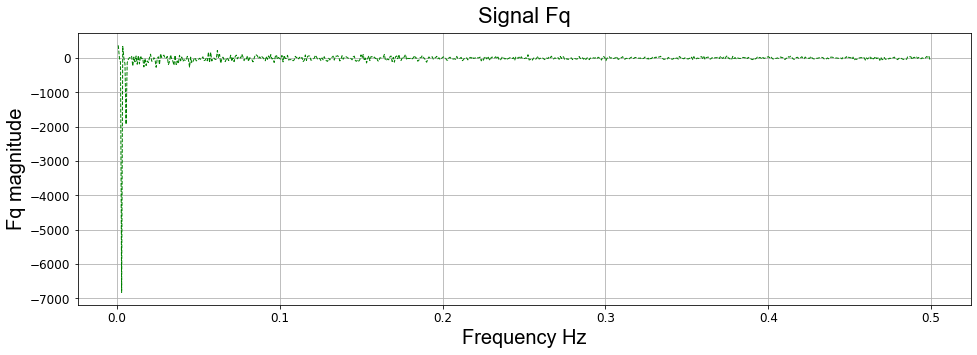

In [77]:
def fq_analysis(signal, delta_t):

    # FFT for frequency spectrum. 
    spectrum = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(spectrum), delta_t)
    plt_ind = freq > 0.0001

    ## Get Power Spectral Density
    signalPSD = 10*np.log10 (np.abs(spectrum) ** 2)

    fig = plt.figure()
    fig.set_size_inches(16, 5)
    plt.grid(True)

    plt.plot(freq[plt_ind], signalPSD[plt_ind], label="signal PSD", color='g', linestyle="--", linewidth=1)

    plt.xlabel("Frequency Hz", **axis_font)
    plt.ylabel("PSD dB", **axis_font)
    plt.title("Signals Power Spectral Density", **title_font)
    plt.show()

    ####################################################################################################

    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    plt.grid(True)

    X = spectrum[plt_ind].real
    plt.plot(freq[plt_ind], spectrum[plt_ind].real, label="signal Fq", color='g', linestyle="--", linewidth=1)

    plt.xlabel("Frequency Hz", **axis_font)
    plt.ylabel("Fq magnitude", **axis_font)
    plt.title("Signal Fq", **title_font)
    plt.show()

fq_analysis(y, dtu)

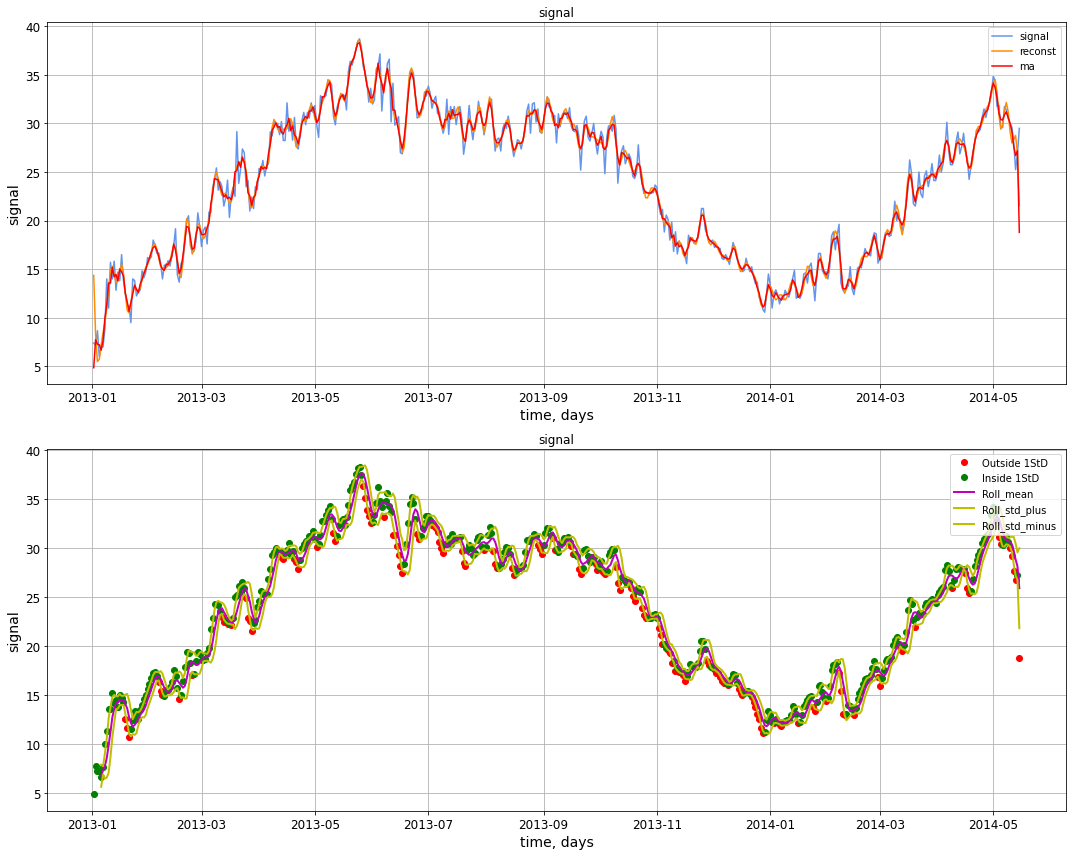

In [86]:
import matplotlib.transforms as mtransforms

def fft_filter(orig_signal, dtu, x_data, fq_thr=0.2, std_f=1):

    # Filter out high fq noise
    fq = np.fft.fft(orig_signal)
    w = np.fft.fftfreq(len(orig_signal), dtu)
    freq_cl = fq.copy()

    freq_cl[(abs(w) > fq_thr)] = 0
    # freq_cl[(abs(w) == 0)] = 0

    reconst = np.fft.ifft(freq_cl)
    reconst = np.real(reconst)


    def round_up_to_odd(f):
        return int(np.ceil(f) // 2 * 2 + 1)

    # Smooth out discrete simulation jitter
    sig_derivative = np.diff(reconst)
    avg_sec = 2
    N = round_up_to_odd(avg_sec/dtu)
    mid = int(np.ceil(N/2))

    step_N = reconst.shape[0]
    step = np.hstack((np.ones(step_N), -1*np.ones(step_N)))

    ups = np.convolve(reconst, step, mode='valid')
    upds = np.diff(ups)

    ma = np.convolve(orig_signal, np.ones(N)/N, mode='same')
    sig_x = ma.copy()
    signal = pd.DataFrame({'Signal': sig_x})


    # Signal X value outside range n-seconds moving average ± X * StdDev
    mov_avg_sec = 4
    roll_wind_len = round_up_to_odd(mov_avg_sec/dtu)

    roll_std = signal["Signal"].rolling(window=roll_wind_len).std()
    roll_mean = signal["Signal"].rolling(window=roll_wind_len).mean()

    idx_roll = np.logical_or(signal["Signal"] <= roll_mean - std_f * roll_std,
                             signal["Signal"] <= roll_mean - std_f * roll_std)

    # idx_roll = np.where(signal["Signal"] <= roll_mean - std_f * roll_std)

    c_ans = np.array(np.where(idx_roll==True))

    indexes = np.zeros(sig_x.shape)
    indexes[c_ans] = 1

    ind = np.array(np.where(indexes), dtype=np.int16)[0]
    ind2 = np.array(np.where(indexes<1), dtype=np.int16)[0]


    fig, ax = plt.subplots(2)
    fig.set_size_inches(15, 12)
    # To mark the area mean ± StdDev
    trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)


    ax[0].plot(x_data, orig_signal, color='cornflowerblue', label='signal')
    ax[0].plot(x_data, reconst, color='darkorange', label='reconst')
    ax[0].plot(x_data, ma, color='r', label='ma')


    ax[1].plot(x_data[ind], sig_x[ind], label="Outside 1StD", color='r', linestyle="None", marker="o", linewidth=2)
    ax[1].plot(x_data[ind2], sig_x[ind2], label="Inside 1StD", color='g', linestyle="None", marker="o", linewidth=2)

    ax[1].plot(x_data, roll_mean, label="Roll_mean", color='m', linestyle="-", linewidth=2)
    ax[1].plot(x_data, roll_mean+std_f*roll_std, label="Roll_std_plus", color='y', linestyle="-", linewidth=2)
    ax[1].plot(x_data, roll_mean-std_f*roll_std, label="Roll_std_minus", color='y', linestyle="-", linewidth=2)


    ax[0].set(xlabel='time, days', ylabel='signal', title='signal')
    ax[0].grid(which='both')
    ax[0].legend(loc='upper right')

    ax[1].set(xlabel='time, days', ylabel='signal', title='signal')
    ax[1].grid(which='both')
    ax[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    fig.savefig('signal_std_mean.png')
    plt.close()

fft_filter(y[1:500], dtu, raw_df.index[1:500], fq_thr=0.2, std_f=1)
# fft_filter(y, dtu, raw_df.index)



<AxesSubplot:xlabel='date'>

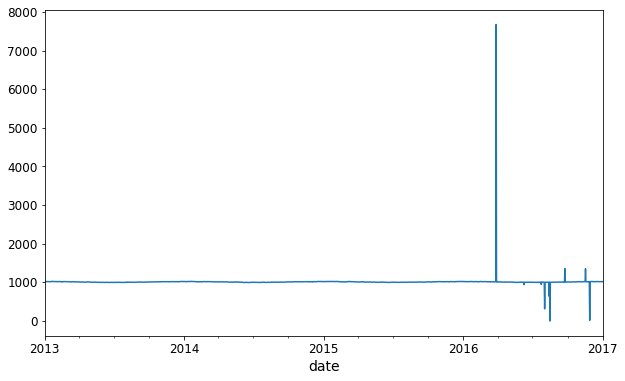

In [79]:
kek = raw_df['meantemp'] * raw_df['humidity'] * raw_df['meanpressure']
kek = raw_df['meanpressure']
kek.plot(figsize=(10, 6))

In [80]:
raw_df.index.freq = 'D'
raw_df['meantemp'].asfreq('Y')

date
2013-12-31    14.500000
2014-12-31    12.375000
2015-12-31    15.000000
2016-12-31    15.052632
Freq: A-DEC, Name: meantemp, dtype: float64